# Deterministic vs Stochastic SLIR Model

In this notebook, we compare **Deterministic** and **Stochastic** implementations of the SLIR (Susceptible-Latent-Infectious-Recovered) model across different transmission rates (Beta).

## Mathematical Model (Discrete Time)

The model is defined by the following system of difference equations:

$$
\begin{aligned}
S(t+1) &= S(t) - \beta S(t) I(t) \\
L(t+1) &= L(t) + \beta S(t) I(t) - \sigma L(t) \\
I(t+1) &= I(t) + \sigma L(t) - \mu I(t) \\
R(t+1) &= R(t) + \mu I(t)
\end{aligned}
$$

Where:
- $S(t), L(t), I(t), R(t)$: Proportions of Susceptible, Latent, Infectious, and Recovered individuals.
- $\beta$: Infection rate (transmission).
- $\sigma$: Rate of progression from Latent to Infectious ($1/\text{latent period}$).
- $\mu$: Recovery rate ($1/\text{infectious period}$).

### Epidemic Threshold

For the SLIR model, the basic reproductive number is given by:
$$
R_0 = \frac{\beta}{\mu}
$$
The epidemic threshold is at $R_0 = 1$. The latency period ($\sigma$) introduces a delay but does not change the condition for an outbreak to start.
If $R_0 > 1$, an epidemic occurs.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

## 1. Simulation Functions

In [3]:
def run_deterministic_slir(beta, mu, sigma, T_max, I0_prop=0.01):
    S0 = 1 - I0_prop
    L0 = 0
    I0 = I0_prop
    R0 = 0
    
    S, L, I, R = [S0], [L0], [I0], [R0]
    
    for t in range(T_max):
        St, Lt, It, Rt = S[-1], L[-1], I[-1], R[-1]
        
        # Flows
        new_exposed = beta * St * It
        new_infectious = sigma * Lt
        new_recovered = mu * It
        
        # Updates
        next_S = St - new_exposed
        next_L = Lt + new_exposed - new_infectious
        next_I = It + new_infectious - new_recovered
        next_R = Rt + new_recovered
        
        S.append(next_S)
        L.append(next_L)
        I.append(next_I)
        R.append(next_R)
        
    return np.array(S), np.array(L), np.array(I), np.array(R)

def run_stochastic_slir(N, beta, mu, sigma, T_max, I0_prop=0.01):
    I_count = int(I0_prop * N)
    S_count = N - I_count
    L_count = 0
    R_count = 0
    
    S, L, I, R = [S_count], [L_count], [I_count], [R_count]
    
    for t in range(T_max):
        # Current states
        curr_S = S[-1]
        curr_L = L[-1]
        curr_I = I[-1]
        
        # Probabilities
        p_inf = beta * curr_I / N # Prob S->L
        p_inf = max(0, min(1, p_inf))
        
        # Events (Binomial draws)
        new_exposed = np.random.binomial(curr_S, p_inf)
        new_infectious = np.random.binomial(curr_L, sigma)
        new_recovered = np.random.binomial(curr_I, mu)
        
        # Updates
        next_S = curr_S - new_exposed
        next_L = curr_L + new_exposed - new_infectious
        next_I = curr_I + new_infectious - new_recovered
        next_R = R[-1] + new_recovered
        
        # Enforce non-negative
        next_S = max(0, next_S)
        next_L = max(0, next_L)
        next_I = max(0, next_I)
        next_R = max(0, next_R)
        
        S.append(next_S)
        L.append(next_L)
        I.append(next_I)
        R.append(next_R)
        
    return np.array(S)/N, np.array(L)/N, np.array(I)/N, np.array(R)/N


## 2. Running Simulations (Varying Beta)

In [4]:
betas = [0.25, 0.40, 0.55, 0.70, 0.85]
mu = 0.1
sigma = 0.25 # 1/4 days latent period
T_max = 100
N = 1000

results_det = {}
results_stoch = {}

for b in betas:
    print(f"Running for beta={b} (R0={b/mu:.2f})...")
    results_det[b] = run_deterministic_slir(b, mu, sigma, T_max)
    # Run a single realization for stochastic plotting
    results_stoch[b] = run_stochastic_slir(N, b, mu, sigma, T_max)


Running for beta=0.25 (R0=2.50)...
Running for beta=0.4 (R0=4.00)...
Running for beta=0.55 (R0=5.50)...
Running for beta=0.7 (R0=7.00)...
Running for beta=0.85 (R0=8.50)...


## 3. Visualization

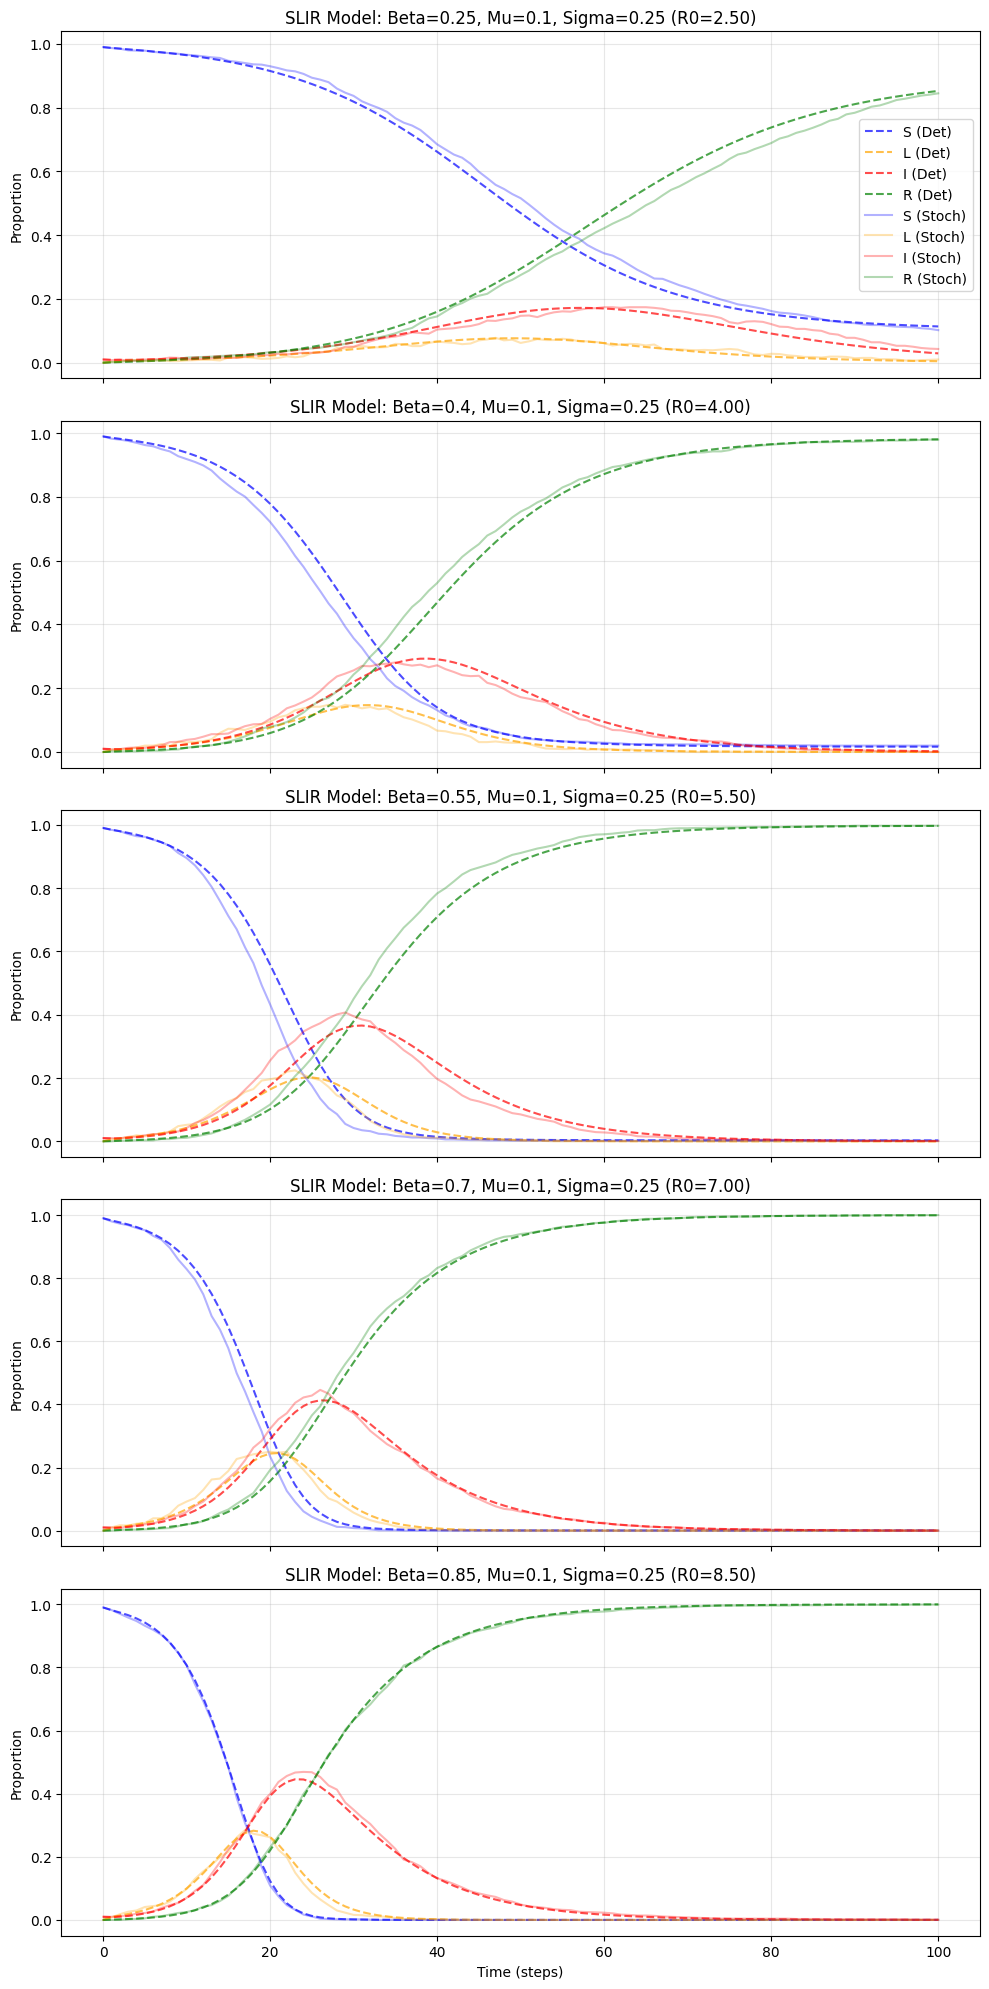

In [5]:
fig, axes = plt.subplots(len(betas), 1, figsize=(10, 4*len(betas)), sharex=True)
if len(betas) == 1: axes = [axes]

for ax, b in zip(axes, betas):
    # Deterministic
    Sd, Ld, Id, Rd = results_det[b]
    t_axis = range(len(Sd))
    ax.plot(t_axis, Sd, 'b--', alpha=0.7, label='S (Det)')
    ax.plot(t_axis, Ld, 'orange', linestyle='--', alpha=0.7, label='L (Det)')
    ax.plot(t_axis, Id, 'r--', alpha=0.7, label='I (Det)')
    ax.plot(t_axis, Rd, 'g--', alpha=0.7, label='R (Det)')
    
    # Stochastic
    Ss, Ls, Is, Rs = results_stoch[b]
    ax.plot(t_axis, Ss, 'b-', alpha=0.3, label='S (Stoch)')
    ax.plot(t_axis, Ls, 'orange', alpha=0.3, label='L (Stoch)')
    ax.plot(t_axis, Is, 'r-', alpha=0.3, label='I (Stoch)')
    ax.plot(t_axis, Rs, 'g-', alpha=0.3, label='R (Stoch)')
    
    R0 = b / mu
    ax.set_title(f'SLIR Model: Beta={b}, Mu={mu}, Sigma={sigma} (R0={R0:.2f})')
    ax.set_ylabel('Proportion')
    ax.grid(True, alpha=0.3)
    if b == betas[0]:
        ax.legend()

axes[-1].set_xlabel('Time (steps)')
plt.tight_layout()
plt.show()
